# NLP with Diaster Disaster tweet - detailed

Hello mọi người! Chúc mọi người có một năm mới vui vẻ, hạnh phúc và đạt được điều mình mong muốn. Khi viết bài này mình đang ở một nơi rất xa rất xa Việt Nam,xa mùi bánh chưng, xa gia đình, xa không khí nhộn nhịp sắp Tết quá. Ước gì bây giờ mình được ở nhà thì thật là tốt biết bao ^^. Năm sau mình sẽ làm nhiều hơn, tham gia học hỏi nhiều hơn nữa để không lãng phí những ngày phải xa gia đình như này. Hy vọng tương lai tươi đẹp thôi nào ^^

![twitter](twitter.jpg)

## 0. Introduction

Đây là một nhiệm vụ cơ bản về Natural Language Processing(NLP) giúp bạn bước đầu làm quen với NLP. Nhiệm vụ yêu cầu dụ đoán dòng tweets trên Twitter có phải về thảm họa hay không https://www.kaggle.com/competitions/nlp-getting-started/overview

Dự liệu của nhiệm vụ gồm 2 tập: 
* **train.csv** gồm 4 cột : text, location, keyword, target
* **test.csv** gồm 3 cột : text, location, keyword

Tập train có 7613 ví dụ, tập test có 3263
* **text** : chứa văn bản của tweet
* **location** : chứa địa chỉ của người đăng
* **keyword** : chứa từ khóa của tweet
* **target** : 0- không phải thảm họa, 1- thảm họa

Yêu cầu dự đoán có phải là thảm họa hay không cho tập test. Đánh giá scores bằng f1_score

$f1 = 2*\frac{precision*recall}{precision+recall}$


Hãy bắt đầu thôi nào!

## 1.Load data

Như thường lệ, đầu tiên cần load thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from wordcloud import STOPWORDS    #những từ không có ý nghĩa lắm như the, a, and,...
from tqdm import tqdm              # để hiện thanh quá trình cho biết đã chạy được đến đâu
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

ModuleNotFoundError: No module named 'wordcloud'

Tắt cảnh báo

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_data = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv", index_col ='id')
test_data = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv", index_col = 'id')

In [4]:
train_data.shape

(7613, 4)

In [5]:
test_data.shape

(3263, 3)

In [6]:
train_data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 102.0+ KB


Nối dữ liệu tập train và test cho dễ xử lý

In [9]:
data = pd.concat([train_data, test_data])

In [10]:
data.tail()

,keyword,location,text,target
id,,,,
10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,NaN
10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN
10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN
10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN
10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN


## 2. Exploring data analysis

Mỗi nhiệm vụ cần có bước này để khám phá dữ liệu ta có, nghiên cứu xem nên áp dụng cách xử lý nào, mô hình nào

* Số từ trong tweet

In [11]:
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))
train_data['word_count'].describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: word_count, dtype: float64

* Số từ không lặp lại trong tweet

In [12]:
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'].head()

id
0      6
2      9
3     19
9      4
11     8
Name: unique_word_count, dtype: int64

* Số từ stop_word (ko có ý nghĩa lắm)

In [13]:
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
train_data['stop_word_count'].head()

id
1     6
4     0
5    11
6     1
7     7
Name: stop_word_count, dtype: int64

* Số url trong tweet

In [14]:
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

* Độ dài trung bình của từ

In [15]:
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

* Độ dài của tweet

In [16]:
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))
train_data['char_count'].max()

157

* Đếm dấu câu

In [17]:
train_data['punctuation_count'] = train_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_data['punctuation_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
train_data['punctuation_count'].head()

id
1    1
4    1
5    3
6    2
7    2
Name: punctuation_count, dtype: int64

* Số hashtag

In [18]:
train_data['hashtag_count']= train_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_data['hashtag_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train_data['hashtag_count'].tail()

id
10869    0
10870    0
10871    0
10872    0
10873    0
Name: hashtag_count, dtype: int64

* Số mention

In [19]:
train_data['mention_count'] = train_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_data['mention_count'] = test_data['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

Vẽ biểu đồ biểu diễn phân phối của các cột trên với câu Disaster và not Disaster trên tập train và test

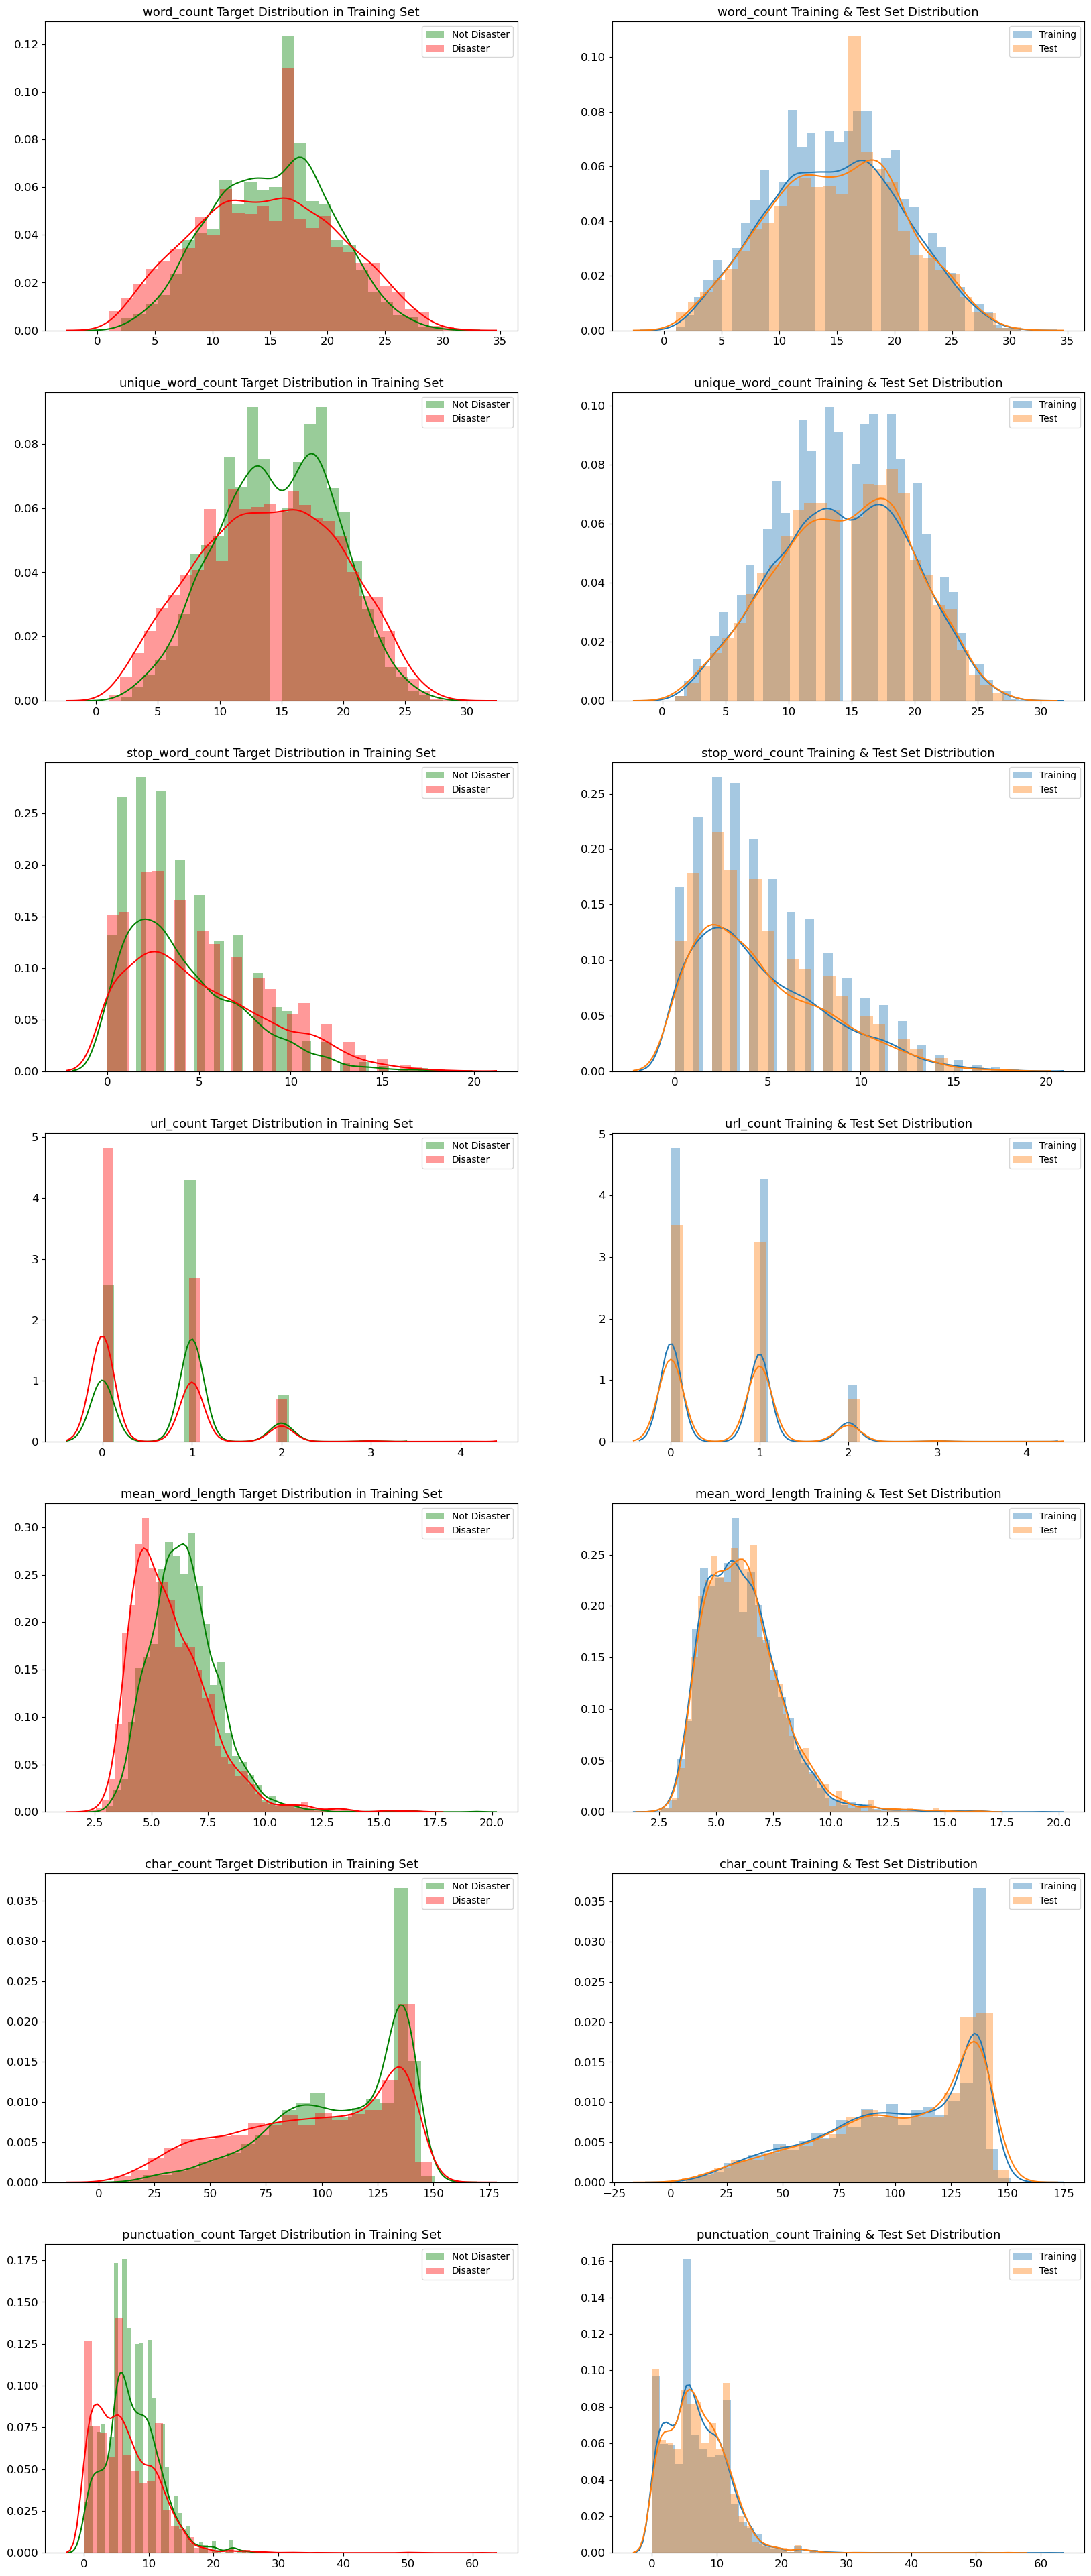

In [26]:
Features= ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length', 'char_count', 'punctuation_count']#, 'hashtag_count', 'mention_count']
fig,axes = plt.subplots(ncols=2, nrows=len(Features), figsize = (20,50), dpi=100)

for i, feature in enumerate(Features):
    sns.distplot(train_data.loc[train_data['target']==1][feature], label = 'Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[train_data['target']==0][feature], label = 'Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

**Comment**: Nhận thấy **word_count**, **unique_word_count**, **stop_word_count**, **mean_word_length**, **char_count**, **punctuation_count** có phân phối khác nhau giữa disaster và not disaster, có cùng kiểu phân bổ giữa tập train và test

Vậy nên chúng ta nên giữ lại những tính năng này

## 3. Preprocessing

Cần xử lý số liệu trước khi cho vào model

Load thư viện text_hammer để xử lý số liệu

In [27]:
!pip install text_hammer
import text_hammer as th

     |████████████████████████████████| 115 kB 5.3 MB/s eta 0:00:01
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.0
    Uninstalling beautifulsoup4-4.9.0:
      Successfully uninstalled beautifulsoup4-4.9.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [28]:
def text_preprocessing(df):
    df.fillna('', inplace = True)
    df['text'] = df['text'] + ' ' + df['keyword'] + ' ' + df['location']
    
    df['text'] = df['text'].progress_apply(lambda x: str(x).lower())
    df['text'] = df['text'].progress_apply(lambda x: th.cont_exp(x))
    df['text'] = df['text'].progress_apply(lambda x: th.remove_emails(x))
    df['text'] = df['text'].progress_apply(lambda x: th.remove_html_tags(x))
    df['text'] = df['text'].progress_apply(lambda x: th.remove_special_chars(x))
    df['text'] = df['text'].progress_apply(lambda x: th.remove_accented_chars(x))
    #df['text'] = df['text'].progress_apply(lambda x: th.make_base(x))
    return df

In [29]:
data_cleaned = text_preprocessing(data)

In [30]:
data_cleaned['text'][1]

'our deeds are the reason of this earthquake may allah forgive us all'

In [31]:
train_data['text'][1]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

Tách ra thành tập train và test

In [32]:
train_data['text'] = data_cleaned[: 7613]['text']
test_data['text'] = data_cleaned[7613:]['text']

In [35]:
train_data['text']

id
1        our deeds are the reason of this earthquake ma...
4                    forest fire near la ronge sask canada
5        all residents asked to shelter in place are be...
6        13000 people receive wildfires evacuation orde...
7        just got sent this photo from ruby alaska as s...
                               ...                        
10869    two giant cranes holding a bridge collapse int...
10870    aria_ahrary thetawniest the out of control wil...
10871    m194 0104 coordinated universal time5km s of v...
10872    police investigating after an ebike collided w...
10873    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

Chúng ta dùng mô hình **Bert** đã được đào tạo trước từ **hugging face** qua **transformers**

In [36]:
!pip install transformers
import transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [37]:
 from transformers import BertTokenizer
import tensorflow as tf
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case = True)    #hàm mã hóa token của model BERT

In [38]:
def bert_encode(data,max_length) :                 #hàm mã hóa văn bản đầu vào thành token vào mô hình BERT
    input_ids = []                                     #token của input
    attention_masks = []                  #mặt nạ cho attention

    for text in data.text:
        encoded = tokenizer.encode_plus(      #mã hóa text
            text,
            add_special_tokens = True,
            max_length = max_length,
            pad_to_max_length= True,               #pad thêm cho tất cả cùng đọ dài max_length
            return_attention_mask = True,
        )    
    
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Giờ chúng ta hãy mã hóa dữ liệu để bắt đầu train mô hình thôi nào

In [39]:
train_input_ids,train_attention_masks = bert_encode(train_data,60)
test_input_ids,test_attention_masks = bert_encode(test_data,60)

## 4. Model

Dùng mô hình TFBertModel được đào tạo trước từ hugging face

**Comment**: Có thể dùng mô hình DistilBert, RoBERTa, AlBERT là những phiên bản cải tiến của Bert

In [40]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

**Comment**: Nếu chỉ sử dụng mô hình Bert và parameters có sẵn thì mô hình sẽ không phù hợp với dữ liệu của ta.  Vì vậy dùng pretrained và thay đổi vài lớp đầu ra cuối cùng 

In [41]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def create_model(bert_model):    
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')           #khởi tạo đầu vào cho input_ids
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')        #khởi tạo đầu vào cho attention_masks
  
    output = bert_model([input_ids,attention_masks])               #dùng model bert có sẵn
    output = output[1]                        #lấy pooler_output cho nhiệm vụ phân loại
    output = tf.keras.layers.Dense(32,activation='relu')(output)          #áp dụng lớp neutron 32 nút
    output = tf.keras.layers.Dropout(0.2)(output)                      #giảm bớt giá trị để mô hình không bị overfitting

    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)           #khai báo đầu vào và ra cuối cùng (như pipeline)
    model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [42]:
model = create_model(bert_model)
model.summary()     #trực quan hóa mô hình

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 1024), ( 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

In [43]:
history = model.fit([train_input_ids,train_attention_masks],train_data.target,validation_split=0.2, epochs=2,batch_size=10)        #đào tạo mô hình qua 2 epoch

Train on 6090 samples, validate on 1523 samples
Epoch 1/2
6090/6090 [==============================] - 197s 32ms/sample - loss: 0.4888 - accuracy: 0.7688 - val_loss: 0.3964 - val_accuracy: 0.8378
Epoch 2/2
6090/6090 [==============================] - 168s 28ms/sample - loss: 0.3908 - accuracy: 0.8427 - val_loss: 0.4264 - val_accuracy: 0.8207


Vẽ biểu đồ khảo sát hiệu suất của mô hình qua các epoch

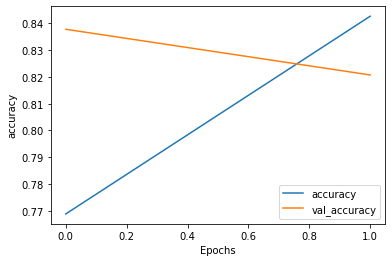

In [44]:
def plot_graphs(history, string):       
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show
    
plot_graphs(history, 'accuracy')

Comment: Vì chỉ có 2 epoch nên biểu đồ trên không đánh giá được gì, nhưng đối với nhiều epoch sẽ giúp đánh giá mô hình có bị overfitiing hay underfitting không

Vẽ biểu đồ tính confusion_matrix

In [45]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

In [ ]:
y_train_pred = model.predict([train_input_ids, train_attention_masks])

displayConfusionMatrix(train_data.target, (y_train_pred>0.5).astype(int), "Train")

## 4. Output

In [49]:
y_pred = model.predict([test_input_ids, test_attention_masks])
y_pred = (y_pred>0.5).astype(int).flatten()

In [50]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [51]:
output = pd.DataFrame({'id': test_data.index, 'target': y_pred})
output.to_csv('sample_submission1.csv', index = False)

In [52]:
output

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1
